## makemore: becoming a backprop ninja

In [10]:
# there no change change in the first several cells from last lecture

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [12]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-06-30 21:13:10--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-06-30 21:13:10 (5.09 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [13]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [14]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [15]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
# ok biolerplate done, now we get to the action:

In [17]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [18]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [19]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [237]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3471, grad_fn=<NegBackward0>)

In [238]:
# logits = h @ W2 + b2
# dlogits/dh = 

In [239]:
# c (3x4) = a(3x2) @ b(2x4)

# c (3x4) @ b^-1(4x2) = a(3x2)

# a11 a12
# a21 a22
# a31 a32

# b11 b12 b13 b14
# b21 b22 b23 b24

# c11 = a11 * b11 + a12 * b21 | a11 * b12 + a12 * b22 | ...
# c21 = a21 * b11 + a22 * b21 | a21 * b12 + a22 * b22 | ...
# c31 = a31 * b11 + a32 * b21 | a31 * b12 + a32 * b22 | ...

# b11 | b12 | b13 | b14
#  0. |  0. |. 0. |. 0
#  0  |  0. |. 0  |  0

# dc11 = b11/da11 + b21/da12

# dL/da_1,1 = dL/dd_1,1*dd_1,1/da_1,1 + dL/dd_1,2*dd_1,2/da_1,1
#                       b_1,1                     b_1,2


# dL/db = dL/dc * dc/db
# dL/db = dL/dc * 1

# dL/dbngain = dL/dhpre * dhpre/dbngain
#                         bnraw

# dL/dbndiff2 = dL/dbnvar * dbnvar/dbndiff2
                            

W2.shape

torch.Size([64, 27])

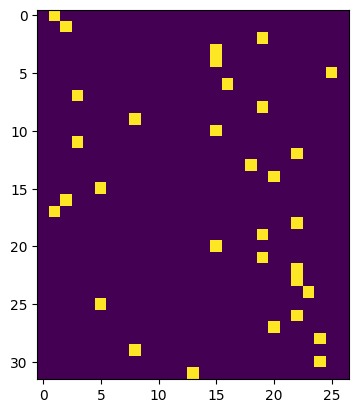

In [240]:
plt.imshow(dlogits_maxmat)

In [241]:
demb[0]

tensor([[ 5.3935e-04, -1.5308e-03,  3.5536e-04,  7.8326e-04, -1.3437e-03,
         -3.0134e-03,  4.7998e-03,  8.3405e-05,  4.2805e-05,  2.1478e-03],
        [-2.3346e-03,  1.1557e-03,  1.8261e-03,  3.7018e-03, -6.5865e-04,
         -2.2421e-04,  1.0325e-03,  2.9088e-03,  3.6548e-03, -4.5196e-03],
        [ 3.7712e-03,  4.4422e-03,  1.6773e-04,  5.1375e-03, -5.0867e-03,
          1.1939e-03,  4.0165e-03,  1.6160e-03,  4.8546e-03, -1.7404e-03]],
       grad_fn=<SelectBackward0>)

In [242]:
demb

tensor([[[ 5.3935e-04, -1.5308e-03,  3.5536e-04,  7.8326e-04, -1.3437e-03,
          -3.0134e-03,  4.7998e-03,  8.3405e-05,  4.2805e-05,  2.1478e-03],
         [-2.3346e-03,  1.1557e-03,  1.8261e-03,  3.7018e-03, -6.5865e-04,
          -2.2421e-04,  1.0325e-03,  2.9088e-03,  3.6548e-03, -4.5196e-03],
         [ 3.7712e-03,  4.4422e-03,  1.6773e-04,  5.1375e-03, -5.0867e-03,
           1.1939e-03,  4.0165e-03,  1.6160e-03,  4.8546e-03, -1.7404e-03]],

        [[-1.4828e-03, -4.0757e-03, -6.1243e-04,  6.7813e-03,  1.7882e-03,
          -6.1342e-03,  3.6754e-03, -1.8913e-03, -2.3356e-03,  1.4082e-03],
         [-1.3780e-03, -2.5266e-03, -4.9496e-04, -1.2087e-03,  2.6468e-03,
          -4.4593e-03,  6.3397e-04, -2.7163e-03,  1.6697e-03,  7.9554e-04],
         [ 1.9671e-03, -2.1791e-03,  5.7139e-04,  2.8990e-04, -6.1014e-03,
           5.6128e-04, -2.6025e-03, -3.0784e-04, -2.1888e-03,  7.5408e-03]],

        [[-7.3335e-04, -4.1496e-03,  5.1946e-03,  5.4497e-03,  2.2966e-03,
           5.80

In [243]:
Xb.shape

torch.Size([32, 3])

In [244]:
dC[1]

tensor([-0.0029, -0.0090,  0.0250, -0.0033,  0.0291, -0.0112, -0.0057, -0.0062,
        -0.0070, -0.0014], grad_fn=<SelectBackward0>)

In [245]:
Xb[0,2]

tensor(4)

In [246]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------


dlogprobs = torch.zeros((32,27))
dlogprobs[range(n), Yb] = -1/n

dprobs = 1/probs * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

dcounts_sum = -counts_sum**-2 * dcounts_sum_inv

dcounts = counts_sum_inv * dprobs + dcounts_sum

dnorm_logits = norm_logits.exp() * dcounts

dlogit_maxes = (-dnorm_logits).sum(1, keepdims=True)

dlogits_maxmat = torch.zeros((32,27))
dlogits_maxmat[range(n), logits.max(1).indices] = 1
dlogits = dnorm_logits.clone() + dlogits_maxmat * dlogit_maxes

dh = dlogits @ W2.T

dW2 = h.T @ dlogits

db2 = dlogits.sum(0, keepdims=True)

dhpreact = (1-h**2) * dh

dbngain = (bnraw * dhpreact).sum(0, keepdims=True)

dbnbias = dhpreact.sum(0, keepdims=True)

dbnraw = torch.ones((32,64)) * bngain * dhpreact

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)

dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv

dbndiff2 = torch.ones((32,64)) / (n-1) * dbnvar

dbndiff = 2 * bndiff * dbndiff2 + bnvar_inv * dbnraw

dbnmeani = -dbndiff.sum(0, keepdims=True)

dhprebn = dbndiff + torch.ones((32,64)) / n * dbnmeani

dembcat = dhprebn @ W1.T

dW1 = embcat.T @ dhprebn

db1 = dhprebn.sum(0, keepdims=True)

demb = dembcat.view((32,3,10))

dC = torch.zeros((27,10))
for j in range(Xb.shape[0]):
  for k in range(Xb.shape[1]):
    dC[Xb[j,k]] += demb[j,k]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [247]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3471269607543945 diff: 4.76837158203125e-07


In [268]:
dlogits.shape

torch.Size([32, 27])

In [269]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits, 1)
dlogits[range(batch_size), Yb] -= 1
dlogits /= n
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [270]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(7.1526e-07, grad_fn=<MaxBackward1>)


In [271]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain * bnvar_inv / n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [313]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

# kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
  #   loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :)
    dlogits = F.softmax(logits, 1)
    dlogits[range(batch_size), Yb] -= 1
    dlogits /= n

    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)

    dhpreact = (1-h**2) * dh

    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain * bnvar_inv / n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)

    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for j in range(Xb.shape[0]):
      for k in range(Xb.shape[1]):
        dC[Xb[j,k]] += demb[j,k]

  #   dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  #   print(dC.shape)
  #   print(dbnbias.shape)
  #   print(p.data.shape)
  #   print((p.data + (-lr * grad)).shape)
  #   print(grads[-1].shape)
  #   print(parameters[-1].shape)
  #   print(dC.shape)
    for p, grad in zip(parameters, grads):
  #     p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
  #     print(p.data.shape)
  #     print(grad.shape)
      p.data += -lr * grad # new way of swole doge TODO: enable


    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

#     if i >= 100: # TODO: delete early breaking when you're ready to train the full net
#       break

12297
      0/ 200000: 3.8405
  10000/ 200000: 2.1963
  20000/ 200000: 2.3730
  30000/ 200000: 2.4652
  40000/ 200000: 1.9839
  50000/ 200000: 2.3454
  60000/ 200000: 2.4209
  70000/ 200000: 2.0129
  80000/ 200000: 2.3625
  90000/ 200000: 2.1271
 100000/ 200000: 1.9724
 110000/ 200000: 2.3388
 120000/ 200000: 1.9897
 130000/ 200000: 2.4415
 140000/ 200000: 2.2716
 150000/ 200000: 2.2162
 160000/ 200000: 1.9143
 170000/ 200000: 1.8019
 180000/ 200000: 1.9636
 190000/ 200000: 1.8715


In [300]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(30, 200)       | exact: False | approximate: True  | maxdiff: 9.313225746154785e-09
(200,)          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(27,)           | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))